<a href="https://colab.research.google.com/github/raphaelreinauer/Deep_Q_learning/blob/master/DQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

# standard learning plot function
def plot_learning_curve(x, scores, epsilons, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0,t-100):(t+1)])
    
    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    plt.savefig(filename)


class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        #first fully connected layer with 128 neurons
        self.fc1 = nn.Linear(*input_dims, 128)
        #output layer
        self.fc2 = nn.Linear(128, n_actions)

        #initiate optimzier and loss
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        #set device to cuda if possible
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    # forward propagation
    def forward(self, state):
        layer1 = F.relu(self.fc1(state))
        actions = self.fc2(layer1)

        return actions

class Agent():
    def __init__(self, input_dims, n_actions, lr=0.01, gamma=0.99,\
                 epsilon=1.0, eps_dec=1e-5, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [i for i in range(self.n_actions)]

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action
        
    # decrement epsilon linearly for the epsilon greedy policy
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                if self.epsilon > self.eps_min else self.eps_min
    
    
    def learn(self, state, action, reward, state_):
        self.Q.optimizer.zero_grad()
        states = T.tensor(state, dtype=T.float).to(self.Q.device)
        actions = T.tensor(action).to(self.Q.device)
        reward = T.tensor(reward).to(self.Q.device)
        states_ = T.tensor(state_, dtype=T.float).to(self.Q.device)

        # predicted Q-value
        q_pred = self.Q.forward(states)[actions]

        # maximal Q-value
        q_next = self.Q.forward(states_).max()

        q_target = reward + self.gamma*q_next


        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        # backward propagation
        self.Q.optimizer.step()
        self.decrement_epsilon()

if __name__ == '__main__':
    env = gym.make('CartPole-v1')
    n_games = 10000
    scores = []
    eps_history = []

    # initiate agent
    agent = Agent(lr=0.0001, input_dims=env.observation_space.shape,
                  n_actions=env.action_space.n)
    for i in range(n_games):
        score = 0
        done = False
        obs = env.reset()

        while not done:
            action = agent.choose_action(obs)
            obs_, reward, done, info = env.step(action)
            score += reward
            agent.learn(obs, action, reward, obs_)
            obs = obs_
        scores.append(score)
        eps_history.append(agent.epsilon)

        if i%100 == 0:
            avg_score = np.mean(scores[-100:])
            print('episode', i, 'score %1f avg_score %.1f epsilon %.2f' %
            (score, avg_score, agent.epsilon))

    filename = 'cartpolse_naiv_dqn.png'
    x = [i+1 for i in range(n_games)]
    


episode 0 score 21.000000 avg_score 21.0 epsilon 1.00
episode 100 score 30.000000 avg_score 23.1 epsilon 0.98
episode 200 score 30.000000 avg_score 22.3 epsilon 0.95
episode 300 score 14.000000 avg_score 23.8 epsilon 0.93
episode 400 score 47.000000 avg_score 24.4 epsilon 0.91
episode 500 score 20.000000 avg_score 26.8 epsilon 0.88
episode 600 score 25.000000 avg_score 28.4 epsilon 0.85
episode 700 score 20.000000 avg_score 27.5 epsilon 0.82
episode 800 score 19.000000 avg_score 32.0 epsilon 0.79
episode 900 score 46.000000 avg_score 33.2 epsilon 0.76
episode 1000 score 17.000000 avg_score 35.4 epsilon 0.72
episode 1100 score 56.000000 avg_score 33.5 epsilon 0.69
episode 1200 score 32.000000 avg_score 41.4 epsilon 0.65
episode 1300 score 48.000000 avg_score 37.8 epsilon 0.61
episode 1400 score 35.000000 avg_score 43.1 epsilon 0.57
episode 1500 score 46.000000 avg_score 43.7 epsilon 0.52
episode 1600 score 58.000000 avg_score 43.5 epsilon 0.48
episode 1700 score 16.000000 avg_score 46.4

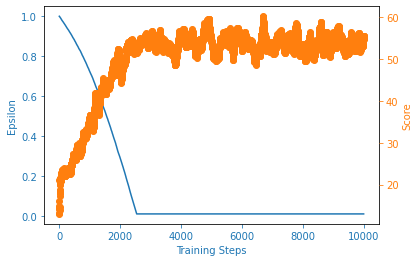

In [0]:
plot_learning_curve(x, scores, eps_history, filename)

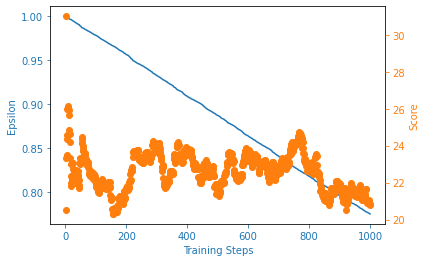

In [0]:
plot_learning_curve(x, scores, eps_history, filename)